<a href="https://colab.research.google.com/github/aaz25/431-2021/blob/main/double_descent_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# Package Installation

In [2]:
! pip install pycox
! pip install torchtuples
! pip install ray[tune]
! pip install torchvision

# Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV

import torch
import torchtuples as tt

from pycox.datasets import flchain
from pycox.simulations import SimStudyNonLinearNonPH
from pycox.models import CoxPH, DeepHitSingle
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.evaluation import EvalSurv

In [4]:
np.random.seed(123)
_ = torch.manual_seed(123)

# FLCHAIN

## Dataset

In [5]:
df_train = flchain.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [6]:
df_train.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death
0,97.0,0.0,1997,5.70,4.860,10,1.7,0.0,85.0,1.0
1,92.0,0.0,2000,0.87,0.683,1,0.9,0.0,1281.0,1.0
2,94.0,0.0,1997,4.36,3.850,10,1.4,0.0,69.0,1.0
3,92.0,0.0,1996,2.42,2.220,9,1.0,0.0,115.0,1.0
5,90.0,0.0,1997,2.01,1.860,9,1.0,0.0,1355.0,1.0


## Feature Transforms

In [7]:
cols_standardize = ['age','sample.yr','kappa','lambda','creatinine']
cols_leave = ['sex','mgus']
cols_categorical = ['flc.grp']

standardize = [([col],StandardScaler()) for col in cols_standardize]
leave = [(col,None) for col in cols_leave]
categorical = [(col,OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize+leave)
x_mapper_long = DataFrameMapper(categorical)

In [8]:
# wrap transform results in a TupleTree
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df).astype('float32'),
                                        x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df).astype('float32'),
                                    x_mapper_long.transform(df))

In [9]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [10]:
get_target = lambda df: (df['futime'].values,df['death'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [11]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

## DeepSurv

### Hyperparameter Tuning

In [25]:
# hyperparameters
in_features = x_train[0].shape[1]
num_nodes = [32]
out_features = 1
batch_norm = True
dropouts = np.linspace(0,0.7,8)
output_bias = False
weight_decays = [0.4,0.2,0.1,0.05,0.02,0.01,0]
batch_sizes = [2**i for i in range(6,11)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = False

In [26]:
estimators = []
params = []
ibs = []

# grid search models
for dropout in dropouts:
  for weight_decay in weight_decays:
    for batch_size in batch_sizes:
      params.append({'dropout':dropout,'weight_decay':weight_decay,
                     'batch_size':batch_size})

      # create model
      net = tt.practical.MixedInputMLP(in_features,num_embeddings,
                                       embedding_dims,num_nodes,out_features,
                                       batch_norm,dropout)
      optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                                  cycle_eta_multiplier=0.8,cycle_multiplier=2)
      model = CoxPH(net,optimizer,device=device)
      estimators.append(model)

      # set initial learning rate
      lr_finder = estimators[-1].lr_finder(x_train,y_train,batch_size,
                                           tolerance=10)
      estimators[-1].optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

      # fit model
      estimators[-1].fit(x_train,y_train,batch_size,epochs,callbacks,verbose,
                         val_data=val,val_batch_size=batch_size)

      # get ibs on validation set
      _ = estimators[-1].compute_baseline_hazards()
      surv = estimators[-1].predict_surv_df(x_val)
      ev = EvalSurv(surv,y_val[0],y_val[1],censor_surv='km')
      time_grid = np.linspace(y_val[0].min(),y_val[0].max(),100)
      ibs.append(ev.integrated_brier_score(time_grid))

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/di

In [30]:
best_params = params[ibs.index(min(ibs))]
best_params

{'dropout': 0.0, 'weight_decay': 0.4, 'batch_size': 64}

### Training

In [15]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Summer 2023/Double Descent/deepsurv_log.txt'

Mounted at /content/drive


In [16]:
in_features = x_train[0].shape[1]
num_nodes = np.arange(4,1025,51)
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False
batch_size = 64
weight_decay = 0.4

epochs = 256
callbacks = None
verbose = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open(path,'w') as f:
  f.write('Num Nodes,Train Score,Test Score\n')

train_score = []
test_score = []

for i in range(0,len(num_nodes)):
  # make model
  net = tt.practical.MixedInputMLP(in_features,num_embeddings,embedding_dims,
                                   [num_nodes[i]],out_features,batch_norm,
                                   dropout)
  optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                              cycle_eta_multiplier=0.8,cycle_multiplier=2)
  model = CoxPH(net,optimizer,device=device)

  # find learning rate
  lr_finder = model.lr_finder(x_train,y_train,batch_size=batch_size,
                              tolerance=10)
  model.optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

  # fit model
  model.fit(x_train,y_train,batch_size,epochs,callbacks,verbose=verbose,
            val_data=val,val_batch_size=batch_size)

  # integrated brier score
  _ = model.compute_baseline_hazards()
  surv_train = model.predict_surv_df(x_train)
  surv_test = model.predict_surv_df(x_test)

  ev_train = EvalSurv(surv_train,y_train[0],y_train[1],censor_surv='km')
  ev_test = EvalSurv(surv_test,durations_test,events_test,censor_surv='km')

  time_grid = np.linspace(durations_test.min(),durations_test.max(),100)

  train_score.append(ev_train.integrated_brier_score(time_grid))
  test_score.append(ev_test.integrated_brier_score(time_grid))

  print(f'num nodes: {num_nodes[i]:4} | train score: {train_score[i]:.04} | \
  test score: {test_score[i]:.04}')

  # save scores
  with open(path,'a') as f:
    f.write(
        f'{num_nodes[i]:4},{train_score[i]:.09},{test_score[i]:.09}\n'
    )

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:    4 | train score: 0.0972 |   test score: 0.09768


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   24 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   44 | train score: 0.09177 |   test score: 0.09888


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   64 | train score: 0.09132 |   test score: 0.1002


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   84 | train score: 0.1356 |   test score: 0.137


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  104 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  124 | train score: 0.09247 |   test score: 0.1058


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  144 | train score: 0.08859 |   test score: 0.1037


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  164 | train score: 0.09316 |   test score: 0.1088


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  184 | train score: 0.0907 |   test score: 0.1017


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  204 | train score: 0.09872 |   test score: 0.09721


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  224 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  244 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  264 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  284 | train score: 0.1016 |   test score: 0.1142


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  304 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  324 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  344 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  364 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  384 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  404 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  424 | train score: 0.08467 |   test score: 0.1105


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  444 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  464 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  484 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  504 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  524 | train score: 0.09819 |   test score: 0.09726


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  544 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  564 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  584 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  604 | train score: 0.144 |   test score: 0.1496


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  624 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  644 | train score: 0.1482 |   test score: 0.1516


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  664 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  684 | train score: 0.08398 |   test score: 0.1066


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  704 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  724 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  744 | train score: 0.1492 |   test score: 0.154


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  764 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  784 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  804 | train score: 0.09095 |   test score: 0.1128


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  824 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  844 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  864 | train score: 0.09923 |   test score: 0.1232


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  884 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  904 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  924 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  944 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  964 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  984 | train score: 0.0872 |   test score: 0.115


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes: 1004 | train score: nan |   test score: nan
num nodes: 1024 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


### Results

In [17]:
df = pd.read_csv(path)
train_score = df['Train Score']
test_score = df['Test Score']
num_nodes = df['Num Nodes']

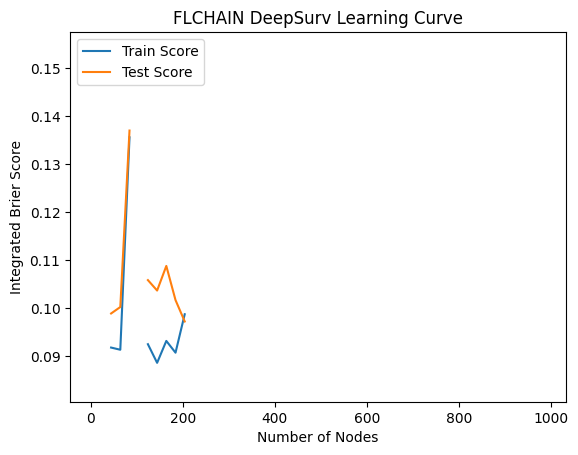

In [18]:
plt.plot(num_nodes,train_score,label='Train Score')
plt.plot(num_nodes,test_score,label='Test Score')
plt.ylabel('Integrated Brier Score')
# plt.xticks(np.arange(0,len(num_nodes)),num_nodes)
# plt.tick_params(axis='x', which='major', labelsize=7.5)
plt.xlabel('Number of Nodes')
plt.title('FLCHAIN DeepSurv Learning Curve')
plt.legend()

## DeepHit

### Label Transforms



In [12]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['futime'].values,df['death'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

durations_test, events_test = get_target(df_test)

### Hyperparameter Tuning

In [35]:
# hyperparameters
in_features = x_train[0].shape[1]
num_nodes = [32]
out_features = labtrans.out_features
batch_norm = True
dropouts = np.linspace(0,0.7,8)
weight_decays = [0.4,0.2,0.1,0.05,0.02,0.01,0]
batch_sizes = [2**i for i in range(6,11)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = False

In [36]:
estimators = []
params = []
ibs = []

# grid search models
for dropout in dropouts:
  for weight_decay in weight_decays:
    for batch_size in batch_sizes:
      params.append({'dropout':dropout,'weight_decay':weight_decay,
                     'batch_size':batch_size})

      # create model
      net = tt.practical.MixedInputMLP(in_features,num_embeddings,
                                       embedding_dims,num_nodes,out_features,
                                       batch_norm,dropout)
      optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                                  cycle_eta_multiplier=0.8,cycle_multiplier=2)
      model = DeepHitSingle(net,optimizer,alpha=0.2,sigma=0.1,
                            duration_index=labtrans.cuts)
      estimators.append(model)

      # set initial learning rate
      lr_finder = estimators[-1].lr_finder(x_train,y_train,batch_size,
                                           tolerance=10)
      estimators[-1].optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

      # fit model
      estimators[-1].fit(x_train,y_train,batch_size,epochs,callbacks,verbose,
                         val_data=val,val_batch_size=batch_size)

      # get ibs on validation set
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv,y_val[0],y_val[1],censor_surv='km')
      time_grid = np.linspace(y_val[0].min(),y_val[0].max(),100)
      ibs.append(ev.integrated_brier_score(time_grid))

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/di

In [37]:
best_params = params[ibs.index(min(ibs))]
best_params

{'dropout': 0.6, 'weight_decay': 0, 'batch_size': 64}

### Training

In [14]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Summer 2023/Double Descent/deephit_flchain_log.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
in_features = x_train[0].shape[1]
num_nodes = np.arange(4,1025,51)
out_features = labtrans.out_features
batch_norm = True
dropout = 0.6
batch_size = 64
weight_decay = 0

epochs = 256
callbacks = None
verbose = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open(path,'w') as f:
  f.write('Num Nodes,Train Score,Test Score\n')

train_score = []
test_score = []

for i in range(0,len(num_nodes)):
  # make model
  net = tt.practical.MixedInputMLP(in_features,num_embeddings,embedding_dims,
                                   [num_nodes[i]],out_features,batch_norm,
                                   dropout)
  optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                              cycle_eta_multiplier=0.8,cycle_multiplier=2)
  model = DeepHitSingle(net,optimizer,alpha=0.2,sigma=0.1,
                        duration_index=labtrans.cuts)

  # find learning rate
  lr_finder = model.lr_finder(x_train,y_train,batch_size=batch_size,
                              tolerance=10)
  model.optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

  # fit model
  model.fit(x_train,y_train,batch_size,epochs,callbacks,verbose=verbose,
            val_data=val,val_batch_size=batch_size)

  # integrated brier score
  surv_train = model.predict_surv_df(x_train)
  surv_test = model.predict_surv_df(x_test)

  ev_train = EvalSurv(surv_train,y_train[0],y_train[1],censor_surv='km')
  ev_test = EvalSurv(surv_test,durations_test,events_test,censor_surv='km')

  time_grid = np.linspace(durations_test.min(),durations_test.max(),100)

  train_score.append(ev_train.integrated_brier_score(time_grid))
  test_score.append(ev_test.integrated_brier_score(time_grid))

  print(f'num nodes: {num_nodes[i]:4} | train score: {train_score[i]:.04} | \
  test score: {test_score[i]:.04}')

  # save scores
  with open(path,'a') as f:
    f.write(
        f'{num_nodes[i]:4},{train_score[i]:.09},{test_score[i]:.09}\n'
    )
  # save state
  torch.save({
      'num_nodes': num_nodes[i],
      'model_state_dict': model.net.state_dict(),
      'optimizer_state_dict': model.optimizer.state_dict(),
      'train_score': train_score[i],
      'test_score': test_score[i],
  },'drive/My Drive/Summer 2023/Double Descent/model.pt')

/usr/local/lib/python3.10/dist-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data = p.data.add(-weight_decay * eta, p.data)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:    4 | train score: 0.3454 |   test score: 0.2448


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   55 | train score: 0.6634 |   test score: 0.1136


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  106 | train score: 0.3486 |   test score: 0.1888


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  157 | train score: 0.3465 |   test score: 0.1892


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  208 | train score: 0.3534 |   test score: 0.1853


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  259 | train score: 0.6359 |   test score: 0.1114


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  310 | train score: 0.6397 |   test score: 0.1111


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  361 | train score: 0.3545 |   test score: 0.1787


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  412 | train score: 0.3639 |   test score: 0.1731


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  463 | train score: 0.3692 |   test score: 0.1729


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  514 | train score: 0.3721 |   test score: 0.1687


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  565 | train score: 0.372 |   test score: 0.1656


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  616 | train score: 0.3754 |   test score: 0.1647


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  667 | train score: 0.3941 |   test score: 0.1598


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  718 | train score: 0.3837 |   test score: 0.1617


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  769 | train score: 0.3885 |   test score: 0.1575


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  820 | train score: 0.3767 |   test score: 0.1643


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  871 | train score: 0.3944 |   test score: 0.1558


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  922 | train score: 0.3833 |   test score: 0.1611


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  973 | train score: 0.3846 |   test score: 0.16
num nodes: 1024 | train score: 0.391 |   test score: 0.1585


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


### Results

In [17]:
df = pd.read_csv(path)
train_score = df['Train Score']
test_score = df['Test Score']
num_nodes = df['Num Nodes']

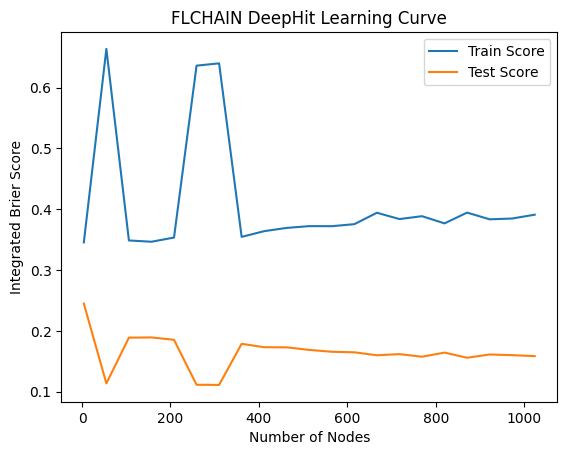

In [18]:
plt.plot(num_nodes,train_score,label='Train Score')
plt.plot(num_nodes,test_score,label='Test Score')
plt.ylabel('Integrated Brier Score')
# plt.xticks(np.arange(0,len(num_nodes)),num_nodes)
# plt.tick_params(axis='x', which='major', labelsize=7.5)
plt.xlabel('Number of Nodes')
plt.title('FLCHAIN DeepHit Learning Curve')
plt.legend()

# RRNLNPH

## Dataset

In [ ]:
sim = SimStudyNonLinearNonPH().simulate(7500) # PLEASE CHANGE: SimStudyNonLinearNonPH(25000)
df_train = SimStudyNonLinearNonPH.dict2df(sim)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
df_train.head()

,x0,x1,x2,duration,event,duration_true,event_true,censoring_true
0,-0.226959,-0.826649,-0.556057,7.951838,1.0,7.951838,1.0,62.345474
2,0.624719,-0.339577,-0.691695,4.980316,0.0,30.976269,1.0,4.980316
4,-0.798489,0.199236,0.313607,4.769782,1.0,4.769782,1.0,27.643553
5,-0.813723,-0.690287,0.201146,14.314299,1.0,14.314299,1.0,15.907827
6,0.517195,0.733943,-0.682266,4.847448,1.0,4.847448,1.0,51.541126


## Feature Transforms

In [ ]:
x_cols = ['x0','x1','x2']

standardize = [([col],StandardScaler()) for col in x_cols]

x_mapper = DataFrameMapper(standardize)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [ ]:
get_target = lambda df: (df['duration'].values,df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [ ]:
x_train.shape

(4800, 3)

## DeepSurv

### Hyperparameter Tuning

In [ ]:
# hyperparameters
in_features = x_train.shape[1]
num_nodes = [32]
out_features = 1
batch_norm = True
dropouts = np.linspace(0,0.7,8)
output_bias = False
weight_decays = [0.4,0.2,0.1,0.05,0.02,0.01,0]
batch_sizes = [2**i for i in range(6,11)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
estimators = []
params = []
ibs = []

# grid search models
for dropout in dropouts:
  for weight_decay in weight_decays:
    for batch_size in batch_sizes:
      params.append({'dropout':dropout,'weight_decay':weight_decay,
                     'batch_size':batch_size})

      # create model
      net = tt.practical.MLPVanilla(in_features,num_nodes,out_features,
                                batch_norm,dropout,output_bias=output_bias)
      optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                              cycle_eta_multiplier=0.8,cycle_multiplier=2)
      model = CoxPH(net,optimizer,device=device)
      estimators.append(model)

      # set initial learning rate
      lr_finder = estimators[-1].lr_finder(x_train,y_train,batch_size,tolerance=10)
      estimators[-1].optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

      # fit model
      estimators[-1].fit(x_train,y_train,batch_size,epochs,callbacks,verbose,
                         val_data=val,val_batch_size=batch_size)

      # get ibs on validation set
      _ = estimators[-1].compute_baseline_hazards()
      surv = estimators[-1].predict_surv_df(x_val)
      ev = EvalSurv(surv,y_val[0],y_val[1],censor_surv='km')
      time_grid = np.linspace(y_val[0].min(),y_val[0].max(),100)
      ibs.append(ev.integrated_brier_score(time_grid))

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/di

In [ ]:
min(ibs)

0.10039456070257453

In [ ]:
best_params = params[ibs.index(min(ibs))]
best_params

{'dropout': 0.0, 'weight_decay': 0.4, 'batch_size': 64}

### Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Summer 2023/Double Descent/deepsurv_log.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
in_features = x_train.shape[1]
num_nodes = np.arange(4,1025,20)
out_features = 1
batch_norm = True
dropout = 0
output_bias = False
batch_size = 64
weight_decay = 0.4

epochs = 256
callbacks = None # [tt.callbacks.EarlyStopping()]
verbose = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open(path,'w') as f:
  f.write('Num Nodes,Train Score,Test Score\n')

train_score = []
test_score = []

for i in range(0,len(num_nodes)):
  # make model
  net = tt.practical.MLPVanilla(in_features,[num_nodes[i]],out_features,
                                batch_norm,dropout,output_bias=output_bias)
  optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                              cycle_eta_multiplier=0.8,cycle_multiplier=2)
  model = CoxPH(net,optimizer,device=device)

  # find learning rate
  lr_finder = model.lr_finder(x_train,y_train,batch_size=batch_size,
                              tolerance=10)
  model.optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

  # fit model
  model.fit(x_train,y_train,batch_size,epochs,callbacks,verbose=verbose,
            val_data=val,val_batch_size=batch_size)

  # integrated brier score
  _ = model.compute_baseline_hazards()
  surv_train = model.predict_surv_df(x_train)
  surv_test = model.predict_surv_df(x_test)

  ev_train = EvalSurv(surv_train,y_train[0],y_train[1],censor_surv='km')
  ev_test = EvalSurv(surv_test,durations_test,events_test,censor_surv='km')

  time_grid = np.linspace(durations_test.min(),durations_test.max(),100)

  train_score.append(ev_train.integrated_brier_score(time_grid))
  test_score.append(ev_test.integrated_brier_score(time_grid))

  print(f'num nodes: {num_nodes[i]:4} | train score: {train_score[i]:.04} | \
  test score: {test_score[i]:.04}')

  # save scores
  with open(path,'a') as f:
    f.write(
        f'{num_nodes[i]:4},{train_score[i]:.09},{test_score[i]:.09}\n'
    )
  # save state
  torch.save({
      'num_nodes': num_nodes[i],
      'model_state_dict': model.net.state_dict(),
      'optimizer_state_dict': model.optimizer.state_dict(),
      'train_score': train_score[i],
      'test_score': test_score[i],
  },'drive/My Drive/Summer 2023/Double Descent/model.pt')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:    4 | train score: 0.1097 |   test score: 0.1143


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   24 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   44 | train score: 0.09689 |   test score: 0.1014


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   64 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   84 | train score: 0.09462 |   test score: 0.09979


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  104 | train score: 0.1191 |   test score: 0.1271


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  124 | train score: 0.09428 |   test score: 0.09939


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  144 | train score: 0.09503 |   test score: 0.09834


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  164 | train score: 0.09404 |   test score: 0.09802


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  184 | train score: 0.09435 |   test score: 0.0985


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  204 | train score: 0.09437 |   test score: 0.09801


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  224 | train score: 0.0941 |   test score: 0.09892


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  244 | train score: 0.09308 |   test score: 0.09685


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  264 | train score: 0.09395 |   test score: 0.09801


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  284 | train score: 0.0947 |   test score: 0.09874


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  304 | train score: 0.09369 |   test score: 0.09881


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  324 | train score: 0.09509 |   test score: 0.09997


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  344 | train score: 0.09435 |   test score: 0.09798


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead

num nodes:  364 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  384 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  404 | train score: 0.1104 |   test score: 0.1178


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  424 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  444 | train score: 0.1207 |   test score: 0.125


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  464 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  484 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  504 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  524 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  544 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  564 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  584 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  604 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead

num nodes:  624 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  644 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  664 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  684 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  704 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  724 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  744 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  764 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  784 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  804 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  824 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  844 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  864 | train score: 0.107 |   test score: 0.1143


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  884 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  904 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  924 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  944 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  964 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  984 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes: 1004 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


num nodes: 1024 | train score: nan |   test score: nan


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


### Results

In [ ]:
df = pd.read_csv(path)
train_score = df['Train Score']
test_score = df['Test Score']
num_nodes = df['Num Nodes']

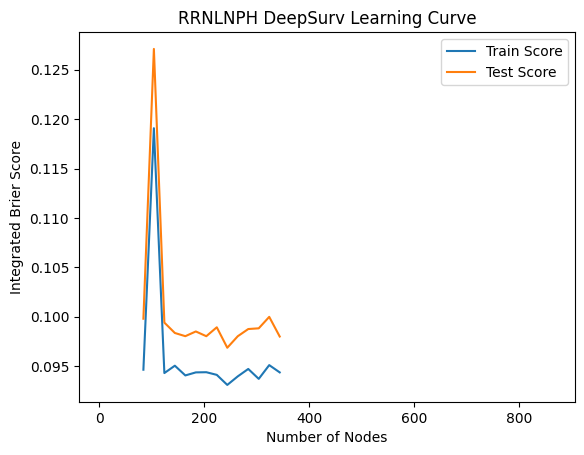

In [ ]:
plt.plot(num_nodes,train_score,label='Train Score')
plt.plot(num_nodes,test_score,label='Test Score')
plt.ylabel('Integrated Brier Score')
# plt.xticks(np.arange(0,len(num_nodes)),num_nodes)
# plt.tick_params(axis='x', which='major', labelsize=7.5)
plt.xlabel('Number of Nodes')
plt.title('RRNLNPH DeepSurv Learning Curve')
plt.legend()

## DeepHit

### Label Transforms

In [ ]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values,df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

durations_test, events_test = get_target(df_test)

### Hyperparameter Tuning

In [ ]:
# hyperparameters
in_features = x_train.shape[1]
num_nodes = [32]
out_features = labtrans.out_features
batch_norm = True
dropouts = np.linspace(0,0.7,8)
weight_decays = [0.4,0.2,0.1,0.05,0.02,0.01,0]
batch_sizes = [2**i for i in range(6,11)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = False

In [ ]:
estimators = []
params = []
ibs = []

# grid search models
for dropout in dropouts:
  for weight_decay in weight_decays:
    for batch_size in batch_sizes:
      params.append({'dropout':dropout,'weight_decay':weight_decay,
                     'batch_size':batch_size})

      # create model
      net = tt.practical.MLPVanilla(in_features,num_nodes,out_features,
                                    batch_norm,dropout)
      optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                                  cycle_eta_multiplier=0.8,cycle_multiplier=2)
      model = DeepHitSingle(net,optimizer,alpha=0.2,sigma=0.1,
                            duration_index=labtrans.cuts)
      estimators.append(model)

      # set initial learning rate
      lr_finder = model.lr_finder(x_train,y_train,batch_size,tolerance=10)
      model.optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

      # fit model
      model.fit(x_train,y_train,batch_size,epochs,callbacks,verbose,
                val_data=val)

      # get ibs on validation set
      surv = model.predict_surv_df(x_val)
      ev = EvalSurv(surv,y_val[0],y_val[0],censor_surv='km')
      time_grid = np.linspace(y_val[0].min(),y_val[0].max(),100)
      ibs.append(ev.integrated_brier_score(time_grid))

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/di

In [ ]:
best_params = params[ibs.index(min(ibs))]
best_params

{'dropout': 0.0, 'weight_decay': 0.4, 'batch_size': 64}

### Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/Summer 2023/Double Descent/deepsdeephit_log.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
in_features = x_train.shape[1]
num_nodes = np.arange(4,1025,20)
out_features = labtrans.out_features
batch_norm = True
dropout = 0
output_bias = False
batch_size = 64
weight_decay = 0.4

epochs = 256
callbacks = None
verbose = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open(path,'w') as f:
  f.write('Num Nodes,Train Score,Test Score\n')

train_score = []
test_score = []

for i in range(0,len(num_nodes)):
  # make model
  net = tt.practical.MLPVanilla(in_features,[num_nodes[i]],out_features,
                                    batch_norm,dropout)
  optimizer = tt.optim.AdamWR(decoupled_weight_decay=weight_decay,
                              cycle_eta_multiplier=0.8,cycle_multiplier=2)
  model = DeepHitSingle(net,optimizer,alpha=0.2,sigma=0.1,
                        duration_index=labtrans.cuts)

  # find learning rate
  lr_finder = model.lr_finder(x_train,y_train,batch_size,tolerance=10)
  model.optimizer.set_lr(10**math.floor(math.log10(lr_finder.get_best_lr())))

  # fit model
  model.fit(x_train,y_train,batch_size,epochs,callbacks,verbose=verbose,
            val_data=val,val_batch_size=batch_size)

  # integrated brier score
  surv_train = model.predict_surv_df(x_train)
  surv_test = model.predict_surv_df(x_test)

  ev_train = EvalSurv(surv_train,y_train[0],y_train[1],censor_surv='km')
  ev_test = EvalSurv(surv_test,durations_test,events_test,censor_surv='km')

  time_grid = np.linspace(durations_test.min(),durations_test.max(),100)

  train_score.append(ev_train.integrated_brier_score(time_grid))
  test_score.append(ev_test.integrated_brier_score(time_grid))

  print(f'num nodes: {num_nodes[i]:4} | train score: {train_score[i]:.04} | \
  test score: {test_score[i]:.04}')

  # save scores
  with open(path,'a') as f:
    f.write(
        f'{num_nodes[i]:4},{train_score[i]:.09},{test_score[i]:.09}\n'
    )
  # save state
  torch.save({
      'num_nodes': num_nodes[i],
      'model_state_dict': model.net.state_dict(),
      'optimizer_state_dict': model.optimizer.state_dict(),
      'train_score': train_score[i],
      'test_score': test_score[i],
  },'drive/My Drive/Summer 2023/Double Descent/model.pt')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:    4 | train score: 0.1548 |   test score: 0.1509


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   24 | train score: 0.1483 |   test score: 0.1429


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   44 | train score: 0.1467 |   test score: 0.1374


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   64 | train score: 0.1493 |   test score: 0.1387


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:   84 | train score: 0.1447 |   test score: 0.1384


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  104 | train score: 0.1447 |   test score: 0.1382


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  124 | train score: 0.1443 |   test score: 0.134


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  144 | train score: 0.1524 |   test score: 0.1386


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  164 | train score: 0.1522 |   test score: 0.1354


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  184 | train score: 0.1498 |   test score: 0.1347


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  204 | train score: 0.15 |   test score: 0.1364


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  224 | train score: 0.1516 |   test score: 0.1382


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  244 | train score: 0.1461 |   test score: 0.1368


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  264 | train score: 0.1375 |   test score: 0.1357


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  284 | train score: 0.1527 |   test score: 0.1352


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  304 | train score: 0.1532 |   test score: 0.1352


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  324 | train score: 0.1535 |   test score: 0.1366


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  344 | train score: 0.1503 |   test score: 0.1398


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  364 | train score: 0.1517 |   test score: 0.1384


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  384 | train score: 0.143 |   test score: 0.1374


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  404 | train score: 0.1485 |   test score: 0.1542


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  424 | train score: 0.1494 |   test score: 0.1377


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  444 | train score: 0.1462 |   test score: 0.1365


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  464 | train score: 0.152 |   test score: 0.1357


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  484 | train score: 0.1444 |   test score: 0.1307


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  504 | train score: 0.1423 |   test score: 0.1355


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  524 | train score: 0.1487 |   test score: 0.1419


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  544 | train score: 0.1386 |   test score: 0.1373


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  564 | train score: 0.1548 |   test score: 0.1344


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  584 | train score: 0.1489 |   test score: 0.1411


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  604 | train score: 0.1492 |   test score: 0.1346


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  624 | train score: 0.146 |   test score: 0.1408


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  644 | train score: 0.1507 |   test score: 0.137


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  664 | train score: 0.1416 |   test score: 0.1377


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  684 | train score: 0.1481 |   test score: 0.1433


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  704 | train score: 0.1458 |   test score: 0.1361


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  724 | train score: 0.1574 |   test score: 0.1418


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  744 | train score: 0.1432 |   test score: 0.1364


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  764 | train score: 0.1495 |   test score: 0.1333


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  784 | train score: 0.1477 |   test score: 0.1379


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  804 | train score: 0.147 |   test score: 0.1349


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  824 | train score: 0.1473 |   test score: 0.1356


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  844 | train score: 0.1518 |   test score: 0.1333


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  864 | train score: 0.1474 |   test score: 0.1397


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  884 | train score: 0.1528 |   test score: 0.139


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  904 | train score: 0.1471 |   test score: 0.1402


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  924 | train score: 0.149 |   test score: 0.1524


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  944 | train score: 0.1506 |   test score: 0.1528


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  964 | train score: 0.1565 |   test score: 0.1354


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes:  984 | train score: 0.1589 |   test score: 0.1405


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


num nodes: 1004 | train score: 0.1373 |   test score: 0.1366
num nodes: 1024 | train score: 0.1356 |   test score: 0.1367


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


### Results

In [ ]:
df = pd.read_csv(path)
train_score = df['Train Score']
test_score = df['Test Score']
num_nodes = df['Num Nodes']

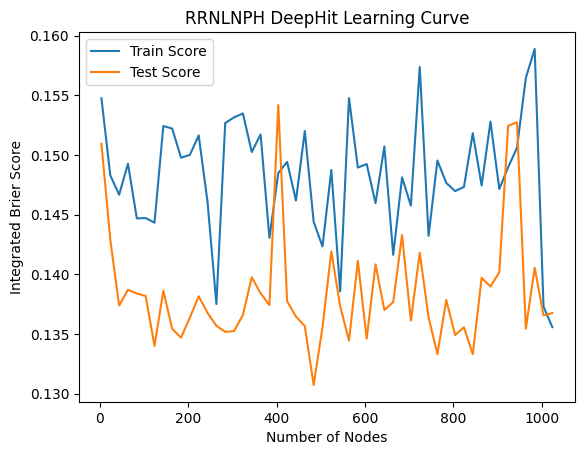

In [ ]:
plt.plot(num_nodes,train_score,label='Train Score')
plt.plot(num_nodes,test_score,label='Test Score')
plt.ylabel('Integrated Brier Score')
# plt.xticks(np.arange(0,len(num_nodes)),num_nodes)
# plt.tick_params(axis='x', which='major', labelsize=7.5)
plt.xlabel('Number of Nodes')
plt.title('RRNLNPH DeepHit Learning Curve')
plt.legend()